# Armed. Object Detection for protection 
Aurthored by : Xlegic Sin'Austin
## ======================================================================

## The Problem and The plan
#### The Goal is to train a model to be able to identify a firearm in a persons possesion.
#### This will be completed in 5 steps.

- Choosing a model
- Setting up the enviorment and model
- Collect, create and extract the training data
- Train and Test the model for accuracy
- Evaluate the results and the project setup, then start from the first step if the model is not performing

## ====================================================================

### Choosing a Model

There are quite a few premade TensorFlow models to choose from so I went over to 
##### https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md 
to have a look at some of the specs of the various models. Initially i didn't know which models to use but I wanted a fast on that wouldnt be too heavy on my system so I used the ssd_mobilenet_v1.
![](./ajupyter_img/1.png)

### Setting up the enviorment
## ======================================================================

I cloned down the entire tensorflow models repository @https://github.com/tensorflow/models and went through the set up.
The most common issues later down the line tend to be caused by not setting your 'PYTHONPATH' correctly to the research directory and the research/slim directory. And other from not running 'python setup.py install' in both the research and research/slim directories. These mistakes result in errors like:
###### No module named 'object_detection' & No module named 'Nets'

### Collecting, Creating, and Extracting the data
## ======================================================================

#### Initially I looked for a "people with firearms" type imageset in the normal imageset databases, yet there didn't seem to be any easily accessible usable imagesets so I opted to create my own.
- First I went to search engines. Bing has a nice copyright tab to sort through the images based on their free-use status giving me a decent number of results with some usable images that I downloaded.


In [26]:
%%html
<img src="ajupyter_img/2.jpg", width=200,height=300> <img src="ajupyter_img/3.png", width=200,height=300> 
<img src="ajupyter_img/4.jpg", width=200,height=300> 

#### After search engines I tried converting other media.
- I found it apparent that I would need get images that had firearms turned in a few diffrented ways under diffrent lighting so I took to videos and use screen caps to get diffrent angles and diffrent lighting. Attempting to cover more bases in my visual data.

In [25]:
%%html
<img src="ajupyter_img/5.png", width=300,height=400> <img src="ajupyter_img/6.png", width=300,height=400> 

#### Filling in the NAN's
There were no numerical nulls since it's image data but there were more obscure angles that I found few photos of.
To fill in these places I took to friends to take pictures of their legally owned weapons from diffrent angles under their choice of lighting. This should keep the model from only being good in the perfect lighting of hollywood and help it perform in real world conditions.

In [27]:
%%html
<img src="ajupyter_img/7.jpg", width=200,height=300> <img src="ajupyter_img/8.jpg", width=200,height=300> 

### Extracting the training data using labelImg
The next step is to locate the target item in the photos and label them with bounding boxes so the model will know what to look toward for feature extraction. I chose to use labelImg to do this. As I labeled every gun in the photos labelImg created a corresponding a xml file with the location of the target on the photo.

In [19]:
%%html
<img src="ajupyter_img/9.png", width=300,hieght=300> <img src="ajupyter_img/10.png", width=300,hieght=300>

#### After the images and xml files were gathered I did a 70:30 split on the data for my training and validation sets.

## Training and Testing the model
## ======================================================================

#### Before I could train the model I needed to do a few things.
        
- create label map for my class/classes
        The sentax is simple but one item is needed for every class being classified
        item {
              id: 1
                  name: 'gun'
            }
            
- convert the XML files to csv files.(That was nice, since csv files are easier to read and work with)
        I used a provided XML_to_CSV.py file to convert all the xml files to a train.csv and test.csv
        
- create a train and test record for my model
        I used a provided generate_tf_record.py file on the csv labels and the image directories to generate the
        train and test records
- obtain and edit a config file for my model
        This is where you setup your model pipeline and how it will run
        Inside the config file I had to change my classes, set my PYTHONPATH, change my batch size and specify 
        my checkpoint file  
        The path to the label map and train+test records needed to be placed in this config file

### Now to the Training.
python legacy/train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/ssd_mobilenet_v1_pets.config
uses the tensorflow provided train.py file to
- specifies to send log data to a file
- where to place the events and checkpoint
- which config file to use to build my model pipeline

## The training to over 3 hours on my initial small set and a deal longer on the full set!
Over those hours I watched the loss bounce up and down but I let the model run through the full set, as the loss was still making it's way down.

## And finally the Testing
#### starting with some imports

In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from utils import label_map_util

from utils import visualization_utils as vis_util

from matplotlib import pyplot as plt
from PIL import Image
import cv2

#This will allow us to us the model on frames of video
stream = cv2.VideoCapture(0)

#I always do so I can see in the notebook.
%matplotlib inline

### Loading in my trained model

In [4]:
MODEL_NAME = './training/trained'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('data', 'labelmap.pbtxt')

NUM_CLASSES = 1

#### using the detection graph from my model

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
#The label map I created earlier is used here    
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)    

##### This turns the test picture colors into values so that the image is represented by an array of scaled values


In [6]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [7]:
# Here The path to my test images and their count is defined
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]
#output image size
IMAGE_SIZE = (14, 14)

In [8]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
     
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
   
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
      
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
       
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')


      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})
        
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

###  The function below 
- turns the photo into an array using the pixel color values
- adds another dimension to the array so it meets the input requirements
- runs the inference graph over the image to detect a firearm.
- places a detection box around what it thinks is a firearm.
- and finally outputs the image with the bounding box around the assumed target/labeled as a gun/how sure it is it's labeled correctly 

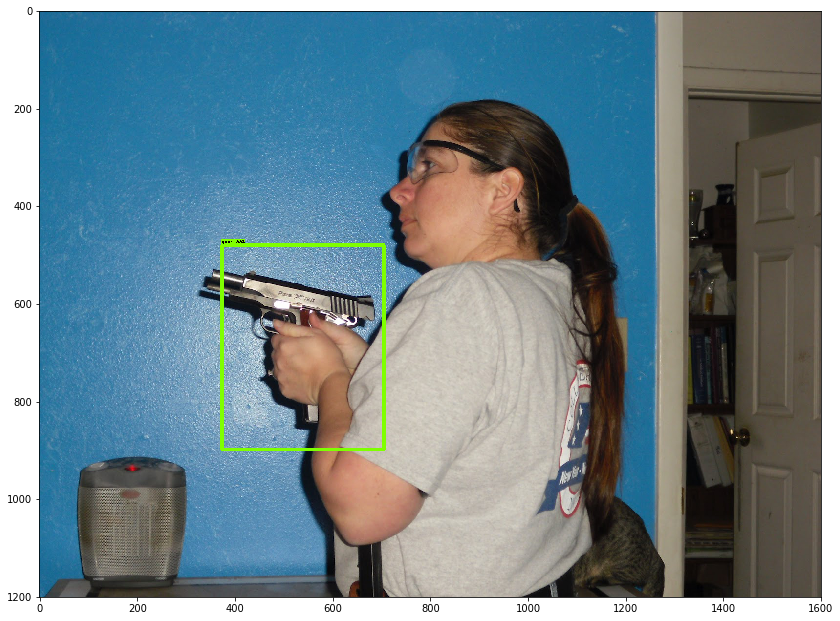

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  image_np = load_image_into_numpy_array(image)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
    


##### It works!   8*}

## I changed the above cell to use cv2 and run the model on a live webcam image

In [12]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        while True:
            ret, image_np = stream.read()
            image_np_expanded = np.expand_dims(image_np, axis=0)
            output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                output_dict['detection_boxes'],
                output_dict['detection_classes'],
                output_dict['detection_scores'],
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=8)
            cv2.imshow('Armed.', cv2.resize(image_np, (800,600)))
            if cv2.waitKey(25) & 0xff == ord('q'):
                cv2.destroyAllWindows()
                break

# It does identify the gun live.

In [24]:
%%html
<img src="ajupyter_img/13.png", width=400,hieght=300> 

In [25]:
%%html
<img src="ajupyter_img/12.png", width=400,hieght=300>

## Evaluation
## ======================================================================

This project shows that object detection of firearms works and given stronger hardware and more training data a model could be a viable way to protect the people we care about. 
The next steps in this project are more training on security footage while considering ethical changes and training. Then the build-out of a popup and warning system.




##### Xlegic.hs@gmail.com